In [14]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [15]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src/data')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src/utils')))

In [21]:
import cv_utils
import file_utils as futils
import data_loader as dload
import yolo_converting as yolo_conv
import torch

from config import DATASET_RAW_FOLDER, ANNOTATIONS_FL_DRONES_DS_FOLDER, \
                    YOLO_ANNOTATIONS_PATH, YOLO_IMAGES_PATH

In [8]:
import tensorflow_hub as hub
from torchvision.io.image import decode_image

E0000 00:00:1739048897.587913    9826 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739048897.603335    9826 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Filter absl warnings
warnings.filterwarnings("ignore", module="absl")
 
# Capture all warnings in the logging system
logging.captureWarnings(True)
 
# Set the absl logger level to 'error' to suppress warnings
absl_logger = logging.getLogger("absl")
absl_logger.setLevel(logging.ERROR)
 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
EfficientDet  = {'EfficientDet D0 512x512'   : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
                 'EfficientDet D1 640x640'   : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
                 'EfficientDet D2 768x768'   : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
                 'EfficientDet D3 896x896'   : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
                 'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
                 'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
                 'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
                 'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1'
                }

In [5]:
model_url = EfficientDet['EfficientDet D1 640x640']
 
print('loading model: ', model_url)
od_model = hub.load(model_url)
 
print('\nmodel loaded!')

loading model:  https://tfhub.dev/tensorflow/efficientdet/d1/1


2025-02-04 18:59:00.227436: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



model loaded!


In [19]:
img = futils.load_image('/home/ezaborshchikov/hse_mc/hse_dl_project/dataset/yolo/images/test/img_58.jpg')
img.shape

(1, 480, 480, 3)

In [13]:
images = []
images.append(img)

In [14]:
results = od_model(images[0])

In [15]:
results = {key:value.numpy() for key, value in results.items()}

In [19]:
class_index =  \
{
         1: 'person',
         2: 'bicycle',
         3: 'car',
         4: 'motorcycle',
         5: 'airplane',
         6: 'bus',
         7: 'train',
         8: 'truck',
         9: 'boat',
         10: 'traffic light',
         11: 'fire hydrant',
         13: 'stop sign',
         14: 'parking meter',
         15: 'bench',
         16: 'bird',
         17: 'cat',
         18: 'dog',
         19: 'horse',
         20: 'sheep',
         21: 'cow',
         22: 'elephant',
         23: 'bear',
         24: 'zebra',
         25: 'giraffe',
         27: 'backpack',
         28: 'umbrella',
         31: 'handbag',
         32: 'tie',
         33: 'suitcase',
         34: 'frisbee',
         35: 'skis',
         36: 'snowboard',
         37: 'sports ball',
         38: 'kite',
         39: 'baseball bat',
         40: 'baseball glove',
         41: 'skateboard',
         42: 'surfboard',
         43: 'tennis racket',
         44: 'bottle',
         46: 'wine glass',
         47: 'cup',
         48: 'fork',
         49: 'knife',
         50: 'spoon',
         51: 'bowl',
         52: 'banana',
         53: 'apple',
         54: 'sandwich',
         55: 'orange',
         56: 'broccoli',
         57: 'carrot',
         58: 'hot dog',
         59: 'pizza',
         60: 'donut',
         61: 'cake',
         62: 'chair',
         63: 'couch',
         64: 'potted plant',
         65: 'bed',
         67: 'dining table',
         70: 'toilet',
         72: 'tv',
         73: 'laptop',
         74: 'mouse',
         75: 'remote',
         76: 'keyboard',
         77: 'cell phone',
         78: 'microwave',
         79: 'oven',
         80: 'toaster',
         81: 'sink',
         82: 'refrigerator',
         84: 'book',
         85: 'clock',
         86: 'vase',
         87: 'scissors',
         88: 'teddy bear',
         89: 'hair drier',
         90: 'toothbrush'
}

In [21]:
R = np.array(np.arange(96, 256, 32))
G = np.roll(R, 1)
B = np.roll(R, 2)
 
COLOR_IDS = np.array(np.meshgrid(R, G, B)).T.reshape(-1, 3)

In [22]:
def process_detection(image, results,  min_det_thresh=.3):
 
    # Extract the detection results from the results dictionary.
    scores  =  results['detection_scores'][0]
    boxes   =  results['detection_boxes'][0]
    classes = (results['detection_classes'][0]).astype(int)
 
    # Set a minimum detection threshold to post-process the detection results.
    min_det_thresh = min_det_thresh
 
    # Get the detections whose scores exceed the minimum detection threshold.
    det_indices = np.where(scores >= min_det_thresh)[0]
 
    scores_thresh  = scores[det_indices]
    boxes_thresh   = boxes[det_indices]
    classes_thresh = classes[det_indices]
 
    # Make a copy of the image to annotate.
    img_bbox = image.copy()
 
    im_height, im_width = image.shape[:2]
 
    font_scale = .6
    box_thickness = 2
 
    # Loop over all thresholded detections.
    for box, class_id, score in zip(boxes_thresh, classes_thresh, scores_thresh):
 
        # Get bounding box normalized coordiantes.
        ymin, xmin, ymax, xmax = box
 
        class_name = class_index[class_id]
 
        # Convert normalized bounding box coordinates to pixel coordinates.
        (left, right, top, bottom) = (int(xmin * im_width), 
                                      int(xmax * im_width), 
                                      int(ymin * im_height), 
                                      int(ymax * im_height))
 
        # Annotate the image with the bounding box.
        color = tuple(COLOR_IDS[class_id % len(COLOR_IDS)].tolist())[::-1]
        img_bbox = cv2.rectangle(img_bbox, (left, top), (right, bottom), color, thickness=box_thickness)
 
        #-------------------------------------------------------------------
        # Annotate bounding box with detection data (class name and score).
        #-------------------------------------------------------------------
 
        # Build the text string that contains the class name and score associated with this detection.
        display_txt = '{}: {:.2f}%'.format(class_name, 100 * score)
        ((text_width, text_height), _) = cv2.getTextSize(display_txt, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)
         
        # Handle case when the label is above the image frame.
        if top < text_height:
            shift_down = int(2*(1.3*text_height))
        else:
            shift_down = 0
         
        # Draw a filled rectangle on which the detection results will be displayed.
        img_bbox = cv2.rectangle(img_bbox, 
                                 (left-1, top-box_thickness - int(1.3*text_height) + shift_down), 
                                 (left-1 + int(1.1 * text_width), top),               
                                 color, 
                                 thickness=-1)
 
        # Annotate the filled rectangle with text (class label and score).
        img_bbox = cv2.putText(img_bbox, 
                               display_txt,
                               (left + int(.05*text_width), top - int(0.2*text_height) + int(shift_down/2)),
                               cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), 1)
    return img_bbox

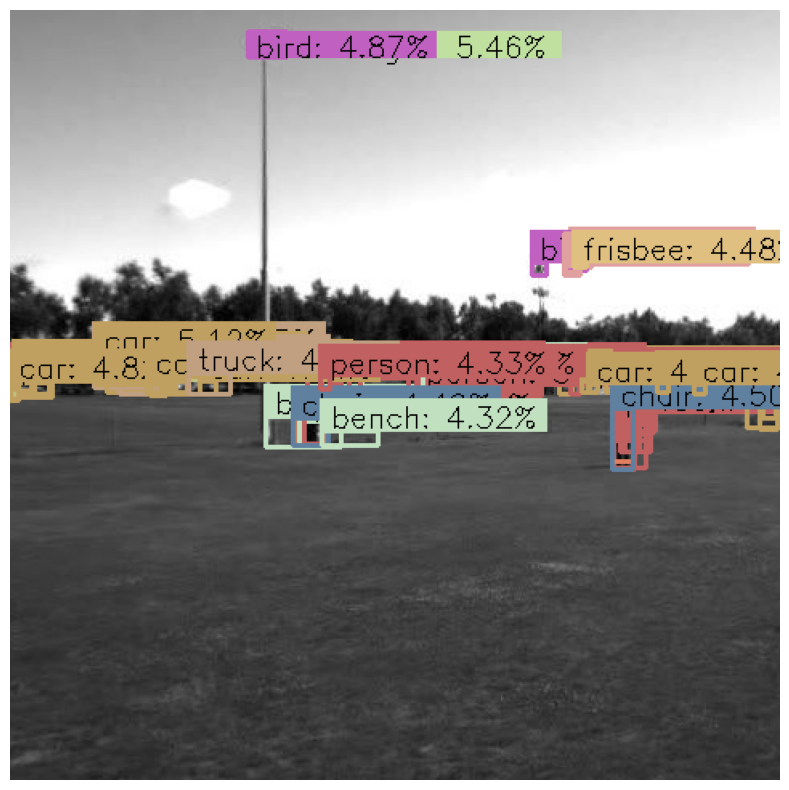

In [24]:
# Call the model.
results = od_model(images[0])
 
# Convert the dictionary values to numpy arrays.
results = {key:value.numpy() for key, value in results.items()}
 
# Remove the batch dimension from the first image.
image = np.squeeze(images[0])
 
# Process the first sample image.
img_bbox = process_detection(image, results, min_det_thresh=0)
 
plt.figure(figsize=[15, 10])
plt.imshow(img_bbox)
plt.axis('off');

In [ ]:
from yolov8 import YOLO
model = YOLO("yolov8m_fly_obj_detection.pt")

In [1]:
from ultralytics.data.converter import convert_coco

In [2]:
import effdet

/home/ezaborshchikov/hse_mc/hse_dl_project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
det = effdet.create_model_from_config()

In [34]:
det.eval()

EfficientDet(
  (backbone): EfficientNetFeatures(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (co

In [35]:
img = decode_image('/home/ezaborshchikov/hse_mc/hse_dl_project/dataset/yolo/images/test/img_58.jpg')
img = img.unsqueeze(dim=0)
img = img.int()
img

tensor([[[[137, 137, 136,  ..., 207, 208, 208],
          [137, 137, 136,  ..., 207, 208, 208],
          [137, 137, 136,  ..., 207, 208, 208],
          ...,
          [ 50,  49,  48,  ...,  48,  48,  47],
          [ 51,  51,  50,  ...,  49,  50,  50],
          [ 50,  51,  51,  ...,  52,  52,  51]],

         [[137, 137, 136,  ..., 207, 208, 208],
          [137, 137, 136,  ..., 207, 208, 208],
          [137, 137, 136,  ..., 207, 208, 208],
          ...,
          [ 50,  49,  48,  ...,  48,  48,  47],
          [ 51,  51,  50,  ...,  49,  50,  50],
          [ 50,  51,  51,  ...,  52,  52,  51]],

         [[137, 137, 136,  ..., 207, 208, 208],
          [137, 137, 136,  ..., 207, 208, 208],
          [137, 137, 136,  ..., 207, 208, 208],
          ...,
          [ 50,  49,  48,  ...,  48,  48,  47],
          [ 51,  51,  50,  ...,  49,  50,  50],
          [ 50,  51,  51,  ...,  52,  52,  51]]]], dtype=torch.int32)

In [36]:
img = img / 255.0

In [37]:
det(img)

RuntimeError: stack expects each tensor to be equal size, but got [1, 88, 8, 8] at entry 0 and [1, 88, 10, 10] at entry 1